In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip -qq "/content/gdrive/MyDrive/imagenet.zip"

In [3]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

Given a
rectangular image, we first rescaled the image such that the shorter side was of length 256, and then
cropped out the central 256×256 patch from the resulting image.

-----> 이미지가 256보다 작다면 256으로 늘리고, 256보다 크다면 centercrop한다

근데 이게 시간이 너무 오래 걸려서 임의로 30%만 사용한다

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 사용자 정의 전처리 함수
def custom_preprocess_input(image):
    image = tf.image.resize(image, (256, 256))  # 이미지 크기를 256x256으로 조정
    image = tf.image.central_crop(image, 1.0)  # 이미지 중앙에서 크롭
    image = tf.image.random_crop(image, size=[224, 224, 3])
    return image

# 이미지 데이터 제너레이터를 설정합니다.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=custom_preprocess_input,
                                   horizontal_flip=True,
                                   validation_split=0.7)  # 데이터의 70%를 검증 데이터로 사용하도록 설정

train_generator = train_datagen.flow_from_directory(
        '/content/imagenet1k',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',  # 'categorical' for multi-class problems
        subset='training')  # training 데이터만 사용


Found 30001 images belonging to 1000 classes.


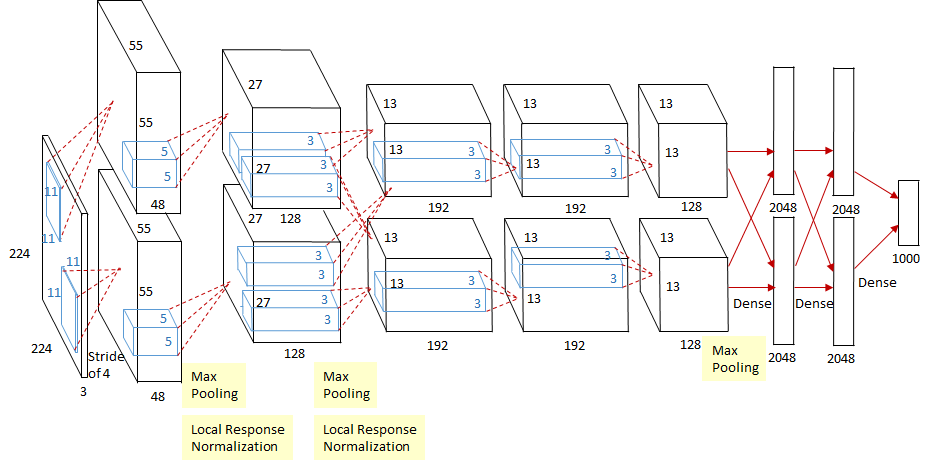

일단 병렬화는 구현을 못하겠다. ㅠㅠㅠㅠㅠ 코랩이라 힘들듯. 일단 구조라도 최대한 만들어 보도록 하자.

In [21]:
model = tf.keras.models.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second convolutional layer
    tf.keras.layers.Conv2D(256, (5, 5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Third convolutional layer
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

    # Fourth convolutional layer
    tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

    # Fifth convolutional layer
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flattening the output of the last convolutional layer
    tf.keras.layers.Flatten(),

    # First fully-connected layer
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Second fully-connected layer
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
])


In [22]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.fit(train_generator, epochs=5)

Epoch 1/5
235/235 [==============================] - 284s 1s/step - loss: 12.7572 - accuracy: 0.0011
Epoch 2/5
235/235 [==============================] - 284s 1s/step - loss: 11.8814 - accuracy: 0.0010
Epoch 3/5
235/235 [==============================] - 283s 1s/step - loss: 11.5365 - accuracy: 0.0011
Epoch 4/5
235/235 [==============================] - 283s 1s/step - loss: 11.4592 - accuracy: 0.0011
Epoch 5/5
235/235 [==============================] - 283s 1s/step - loss: 11.3394 - accuracy: 0.0011


ValueError: could not broadcast input array from shape (224,224,3) into shape (224,2224,3)